In [1]:
import pandas as pd
import simPA_scripts as simPA
import gseapy as gp # needs to be v1.0.6 until they push the bug fix #239 (hopefully v1.1.2)
from scipy.stats import norm
import cobra
import re
import numpy as np

## Model
### Set variables

In [2]:
# model_name = "Recon2.2" # For output file naming purposes
model_name = "Human1" # For output file naming purposes
inpath = "../data/"+model_name+"/py_input/"
outpath = "../data/"+model_name+"/r_input/"

In [3]:
if model_name == "Recon2.2":
    # Set path to local file
    model = cobra.io.read_sbml_model("/home/juliette/work/data/models/Recon2/Recon2.2_Swainton2016_no_b.xml")
    # List of pathway names to exclude from the analysis
    pathways_to_remove = ["Miscellaneous", "Exchange/demand reaction", "Transport, endoplasmic reticular", "Transport, golgi apparatus", "Transport, lysosomal", "Transport, peroxisomal", "Transport, mitochondrial", "Transport, nuclear", "Transport, extracellular", "Dietary fiber binding"]
    metab_suffix = "_e" # This is the suffix for exchange metabolites in the model
    metab_pattern = r'_[a-z]$'
    exchange_rxn_prefix = "EX_" # This is the prefix for exchange reactions in the model

elif model_name == "Human1":
    # Set path to local file
    model = cobra.io.read_sbml_model("/home/juliette/work/data/models/Human1/1.11/Human-GEM.xml")
    # List of pathway names to exclude from the analysis
    pathways_to_remove = ["Miscellaneous","ROS detoxification","Pool reactions","Artificial reactions","Isolated","Dietary fiber binding","Exchange/demand reactions","Transport reactions","Triacylglycerol synthesis"]
    removed_but_ran = ['Pool reactions',
                       'Dietary fiber binding',
                       'Artificial reactions',
                       'ROS detoxification',
                       'Isolated']
    metab_suffix = "e" # This is the suffix for exchange metabolites in the model
    metab_pattern = r'[a-z]$'
    exchange_rxn_prefix = "" # This is the prefix for exchange reactions in the model

Create a version of the model without blocked reactions, and save it as an SBML file if needed. The model without blocked reactions will be used for the rest of this notebook.

In [4]:
# Remove blocked reactions (this file can be created using cobra.flux_analysis.find_blocked_reactions(model))
blocked_reactions = pd.read_csv(inpath+"BKrxns_"+model_name+".txt", header=None)
blocked_reactions = blocked_reactions[0].tolist()
model.remove_reactions(blocked_reactions)
model_c, d_metab = cobra.manipulation.prune_unused_metabolites(model)

/home/juliette/miniforge3/envs/spyder/lib/python3.12/site-packages/cobra/core/group.py:147: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [5]:
# Uncomment to write the sbml model without blocked reactions.
# cobra.io.write_sbml_model(model_c, "/home/juliette/work/data/models/Recon2/Recon2.2_no_blocked.xml")

### Pathways

In [6]:
# Get list of all metabolites and their respective pathway(s)
metabs = []
subsystems = []
for m in model_c.metabolites:
    for r in m.reactions:
        metabs.append(m.id)
        subsystems.append(r.subsystem)
# Join metabs and subsystems as a dataframe
pathways = pd.DataFrame({'metabolite': metabs, 'subsystem': subsystems})
pathways_wide = pathways.pivot(columns="subsystem", values="metabolite")

# Pathway dictionary
pathways_no_comp = {}
pathways_d = {}
for p in pathways_wide.columns:
    pathways_no_comp[p] = []
    pathways_d[p] = []
    for m in pathways_wide[p]:
        if not pd.isna(m):
            pathways_no_comp[p].append(re.sub(metab_pattern, '', m))
            pathways_d[p].append(m)
    pathways_no_comp[p] = list(set(pathways_no_comp[p]))
    pathways_d[p] = list(set(pathways_d[p]))

pathway_ids = [g.id for g in model_c.groups]
pathways_names = [g.name for g in model_c.groups]
pathway_names = pd.DataFrame({'Group': pathway_ids, 'Pathway': pathways_names})

In [7]:
blocked_pathways = [p for p in pathway_names["Pathway"].to_list() if p not in pathways_no_comp.keys()]

### Metabolite dictionary
Read in the one generated by SAMBA, or create one using the sbml model.

In [7]:
# SAMBA-created metabolite dictionary
# metab_dict = pd.read_csv(outpath +"metab_dict.tsv", sep="\t")
# metab_dict["metabID"] = metab_dict["metabID"].str.replace(metab_pattern, '', regex=True)

In [8]:
# Create metabolite dataframe from model
metab_dict = pd.DataFrame(columns=["ID", "Name", "metabID"])
for e in model_c.exchanges:
    met = list(e.metabolites.keys())[0]
    metab_dict = pd.concat([metab_dict, pd.DataFrame([[e.id, met.name, re.sub(metab_pattern, '', met.id)]], columns=["ID", "Name", "metabID"])])

### Z-scores

In [9]:
# Change this path if needed
z_scores = pd.read_csv('../data/large/'+model_name+'_zscores.tsv', sep='\t').set_index("Metab")
#Filter to only keep exchange reaction scores
exchange_reactions = pd.DataFrame([r.id for r in model.exchanges], columns=["exch"])
z_scores_exch = z_scores.loc[exchange_reactions.iloc[:,0].tolist(),:]
z_scores_exch.replace([np.inf, -np.inf], np.nan, inplace=True)
z_scores_exch.rename(index=dict(metab_dict[["ID", "metabID"]].values), inplace=True)
# Convert metabolite IDs to names
z_scores_exch.rename(index=dict(metab_dict[["ID","metabID"]].values), inplace=True)
z_scores_exch.rename(columns=dict(pathway_names[["Group","Pathway"]].values), inplace=True)
# Get pathways not in z_scores
infeasible_pathways = [p for p in pathways_names if p not in z_scores_exch.columns]
removed_but_ran = [p for p in z_scores_exch.columns if p not in infeasible_pathways and p in pathways_to_remove]

In [10]:
z_scores_exch = z_scores_exch.loc[:,~z_scores_exch.columns.isin(pathways_to_remove)]
# Transpose
z_scores_t = z_scores_exch.transpose()
z_scores_t.columns.name = None
z_scores_t.index.names = ['subsystem']
z_scores_t.reset_index(inplace=True)
z_scores_t.index.names = ['unique_id']
z_scores_t.reset_index(inplace=True)
z_scores_t.dropna(axis=1, inplace=True)
z_scores_t

,unique_id,subsystem,MAM01374,MAM02556,MAM01296,MAM03044,MAM01403,MAM01174,MAM00932,MAM00545,MAM00228,MAM00242,MAM02957,MAM01570,MAM02909,MAM02772,MAM01410,MAM03134,MAM02120,MAM02108,MAM02642,MAM02614,MAM01648,MAM03117,MAM02560,MAM01965,MAM02387,MAM02389,MAM02746,MAM02125,MAM02184,MAM02360,MAM02426,MAM02471,MAM02724,MAM02993,MAM03089,MAM03135,MAM02040,MAM02630,...,MAM00115,MAM00117,MAM00260,MAM00265,MAM00315,MAM00341,MAM01197,MAM01207,MAM01235,MAM01238,MAM01582,MAM02053,MAM02457,MAM02613,MAM02745,MAM03045,MAM03051,MAM03153,MAM01395,MAM01421,MAM02837,MAM03971,MAM00591,MAM01435,MAM02328,MAM10001,MAM10002,MAM10003,MAM00235,MAM10011,MAM10023,MAM10025,MAM10026,MAM10027,MAM10028,MAM10029,MAM10030,MAM10031,MAM10034,MAM10041
0,0,Acyl-CoA hydrolysis,-0.013211,0.014544,-0.017878,-0.013625,-0.013211,-0.013625,-0.015297,-0.013182,-0.013354,-0.013164,0.175852,0.235378,0.175526,-0.233813,0.012990,-0.031186,0.000966,0.087825,-0.086312,-0.141526,-0.105885,-0.049501,-0.016519,0.054482,-0.152414,-0.061145,-0.310248,0.214961,-0.126125,0.233994,0.288004,-0.220388,-0.083110,0.144644,0.158844,0.107423,0.074495,0.051560,...,0.105649,-0.048900,-0.076502,0.071763,0.056225,-0.054694,0.011382,0.027205,0.009637,-0.005717,-0.012432,-0.180308,-0.190665,-0.178907,0.054098,0.081939,0.050430,-0.082675,-0.027688,-0.094897,-0.066341,0.018916,-0.122307,0.099274,0.019528,0.007213,0.013164,-0.011370,-0.043388,-0.270150,0.145213,0.119775,-0.027762,-0.040567,0.024801,-0.069278,0.047543,-0.119775,-0.128000,0.084682
1,1,"Alanine, aspartate and glutamate metabolism",0.038023,-0.002668,0.027932,0.037940,0.038023,0.037940,0.074032,0.038303,0.037427,0.039318,0.125877,-0.425595,0.267343,-0.169322,-0.202055,-0.152041,-0.299365,0.033609,-0.149797,0.085509,-0.276301,0.074002,-0.635420,0.128722,-1.408311,-1.189037,0.201133,0.141292,-0.313528,0.024868,0.241612,-0.150496,-0.125229,0.168571,-0.048563,-0.054837,-0.089373,-0.037144,...,0.061296,0.043261,-0.108600,-0.062410,-0.060649,-0.123004,0.068567,-0.075078,0.041937,-0.263082,-0.786689,-0.404468,-0.837484,-0.384156,-0.150733,0.119092,0.073456,-0.129991,-0.069100,-0.080594,-0.096998,-0.708178,-0.082576,-0.156019,0.022101,-0.106742,-0.039318,0.007855,-0.180023,-0.211246,0.133314,-0.117696,0.169576,-0.111513,-0.004590,-0.080236,-0.090099,0.117696,-0.106231,0.109581
2,2,Arachidonic acid metabolism,-0.054844,-0.054730,-0.057303,-0.054865,-0.054844,-0.054865,-0.041656,-0.054635,-0.054970,-0.053768,0.199999,-0.271798,0.296363,0.103335,0.114496,-0.098670,0.039891,0.011787,0.005149,0.093815,-0.037908,-0.065803,-0.071458,-0.135098,-0.156211,0.024467,-0.060484,0.111203,0.234645,0.030831,0.022367,-0.054343,-0.150984,0.024724,0.076097,0.316840,0.063029,-0.022214,...,0.150151,0.052375,-0.085651,-0.145392,-0.033802,-0.076895,0.086172,0.023436,-0.018442,0.013164,-0.141303,0.055305,-0.237848,-0.178981,0.023084,0.061903,0.073303,-0.065691,-0.067393,-0.080866,-0.206875,-0.198483,-0.177718,0.015200,0.108530,-0.055556,0.053768,-0.206712,-0.189118,-0.122210,0.111163,0.205165,-0.156217,-0.209038,-0.044315,-0.146198,0.257980,-0.205165,-0.055930,0.144398
3,3,Arginine and proline metabolism,0.112917,0.154581,0.125962,0.113441,0.112917,0.113441,0.160607,0.112014,0.115521,0.120485,0.280616,0.077867,-0.153369,-0.218200,-0.564239,0.066477,-0.292951,0.008536,-0.201426,-0.050242,-0.374791,0.063867,-0.564233,0.149169,-0.944600,-0.806225,0.065190,0.142153,-0.098608,0.015207,-0.188382,-0.437077,-0.445845,-0.326275,-0.380993,0.000503,-0.143609,0.066365,...,-0.404282,-0.064248,-0.072515,-0.105417,-0.061918,-0.107793,-0.146313,-0.149650,-0.201059,-0.292793,-1.041835,-0.522934,-0.822064,-0.372507,-0.053923,-0.165339,-0.011448,-0.121452,-0.073547,-0.094753,-0.035361,-2.471635,-0.061558,0.222112,-0.104081,-0.159879,-0.120485,-0.053008,-0.075513,1.939395,0.215889,0.240830,-0.034491,-0.228372,-0.080191,-0.229489,0.162232,-0.240830,-0.128657,-0.158554
4,4,Ascorbate and aldarate metabolism,-0.052032,-0.048330,-0.065174,-0.051936,-0.052032,-0.051936,-0.029433,-0.052194,-0.

# ORA

In [11]:
p_vals_all = norm.sf(z_scores_t.iloc[:, 2:].abs())*2
p_vals_all_df = pd.DataFrame(data=p_vals_all, index=z_scores_t.index, columns=z_scores_t.iloc[:, 2:].columns)
p_vals_all_df = pd.concat([z_scores_t[['unique_id', 'subsystem']], pd.DataFrame(p_vals_all_df)], axis=1)

background_set = z_scores_t.iloc[:, 2:].columns.tolist()

In [12]:
KEGG = {}
for r in model.exchanges:
    m = list(r.metabolites.keys())[0].id
    KEGG[m] = model.metabolites.get_by_id(m).annotation.get("kegg.compound")
# Write KEGG to csv
pd.DataFrame.from_dict(KEGG, orient="index").to_csv("~/Downloads/KEGG_bg_set.tsv", sep="\t", header=False)

In [12]:
# For a supp figure (uncomment)
#p_vals_all_df.to_csv("../data/"+model_name+"/supp/p_vals_all_df.tsv", sep="\t", index=False)

In [13]:
DA_metabolites_005 = {}
pvals_dict = p_vals_all_df.drop('subsystem', axis=1).set_index('unique_id').to_dict(orient='index')
for k, v in pvals_dict.items():
    # differential_metabolites_Q3[k] = [m for m, z in v.items() if z >= z_scores_solo_upper_quartile[k]]
    DA_metabolites_005[k] = [m for m, p in v.items() if p <= 0.05]
    # print(len([m for m, z in v.items() if z >= z_scores_solo_upper_quartile[k]]))
background_set = z_scores_t.iloc[:, 2:].columns.tolist()

In [14]:
ora_res_005 = {}
for j in z_scores_t['unique_id']:
    ora = simPA.ORA(DA_metabs=DA_metabolites_005[j], pathways=pathways_no_comp, background_set=background_set)
    ora_res = ora.over_representation_analysis()
    ora_res_005[j] =ora_res

In [15]:
ora_res_005_filt = {k: v for k, v in ora_res_005.items() if not v.empty}
ora_res_005_empty = {k: v for k, v in ora_res_005.items() if v.empty}
ora_005_metrics_filt = simPA.get_metrics_ORA(ora_res_005_filt, z_scores_t, 'P-value', 'ID', norm=False)

/home/juliette/miniforge3/envs/spyder/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/juliette/miniforge3/envs/spyder/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/juliette/miniforge3/envs/spyder/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [17]:
unable_to_run_ORA = ora_res_005_empty.keys()
unable_to_run_ORA = z_scores_t[z_scores_t['unique_id'].isin(unable_to_run_ORA)]['subsystem'].to_list()
# Get able to run in ORA
able_to_run_ORA = ora_res_005_filt.keys()
able_to_run_ORA = z_scores_t[z_scores_t['unique_id'].isin(able_to_run_ORA)]['subsystem'].to_list()

Write the raw results and metrics to files (uncomment).

In [18]:
ora_df = pd.concat(ora_res_005_filt)
# ora_df.to_csv(outpath+model_name+"_ORA_pval_005_metrics_external_with_WT_default_all_results.tsv", index=False, sep="\t")
# ora_005_metrics_filt.to_csv(outpath+model_name+"_ORA_pval_005_metrics_external_with_WT_default_all.csv", index=False)

# GSEA

Two GSEA approaches are used here: with signed z-scores (raw) and unsigned z-scores (absolute) as input.

In [19]:
z_scores_gsea = z_scores_exch.T.reset_index(drop=True).T

## GSEA absolute

In [20]:
gsea_res_per_path = {}
for i in z_scores_gsea.columns:
    gsea_res = gp.prerank(rnk=z_scores_gsea.loc[:,i].dropna().abs(), gene_sets=pathways_no_comp, min_size=3)
    gsea_res_per_path[i] = gsea_res.res2d

2025-03-06 10:33:05,418 [WARNING] Duplicated values found in preranked stats: 2.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:33:05,988 [WARNING] Duplicated values found in preranked stats: 3.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:33:06,533 [WARNING] Duplicated values found in preranked stats: 3.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:33:07,064 [WARNING] Duplicated values found in preranked stats: 3.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:33:07,609 [WARNING] Duplicated values found in preranked stats: 3.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:33:08,160 [WARNING] Duplicated values found in preranked stats: 2.93% of genes
The order of those genes will be

In [21]:
for k, v in gsea_res_per_path.items():
    v["unique_id"] = z_scores_t[z_scores_t["unique_id"] == k]["subsystem"].values[0]

Example:

2025-03-06 10:34:40,130 [WARNING] Duplicated values found in preranked stats: 2.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

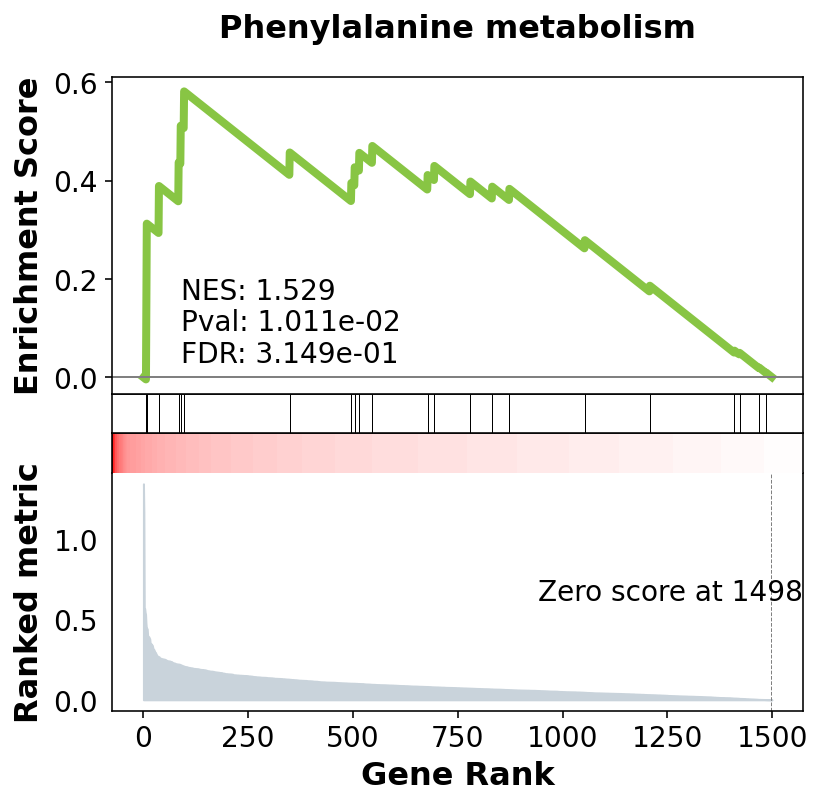

In [23]:
p_id = 45
p_name = "Phenylalanine metabolism"
# gsea_res_per_path[110]
pre_res_abs_TP_example = gp.prerank(rnk=z_scores_gsea.loc[:,p_id].dropna().abs(), gene_sets=pathways_no_comp, min_size=3)
gp.gseaplot(rank_metric=pre_res_abs_TP_example.ranking, term=p_name, **pre_res_abs_TP_example.results[p_name])

Write the GSEA results to files (uncomment).

In [24]:
all_ko_matrix = simPA.get_metrics(gsea_res_per_path, z_scores_t, 'NOM p-val', "Term", NES_pos=True, norm=False)
# all_ko_matrix.to_csv(outpath+model_name+"_GSEA_absolute_metric_external_with_WT_default_all.csv", index=False)
gsea_df = pd.concat(gsea_res_per_path)
# gsea_df.to_csv(outpath+model_name+"_GSEA_absolute_metric_external_with_WT_default_all_results.tsv", index=False, sep="\t")

In [25]:
# Get able to run GSEA
able_to_run_GSEA = gsea_res_per_path.keys()
able_to_run_GSEA = z_scores_t[z_scores_t['unique_id'].isin(able_to_run_GSEA)]['subsystem'].to_list()

## GSEA raw

In [26]:
gsea_res_per_path_raw = {}
for i in z_scores_gsea.columns:
    gsea_res = gp.prerank(rnk=z_scores_gsea.loc[:,i].dropna(), gene_sets=pathways_no_comp, min_size=3)
    gsea_res_per_path_raw[i] = gsea_res.res2d

2025-03-06 10:34:54,305 [WARNING] Duplicated values found in preranked stats: 0.73% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:34:54,894 [WARNING] Duplicated values found in preranked stats: 0.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:34:55,463 [WARNING] Duplicated values found in preranked stats: 0.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:34:56,087 [WARNING] Duplicated values found in preranked stats: 0.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:34:56,677 [WARNING] Duplicated values found in preranked stats: 0.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-06 10:34:57,255 [WARNING] Duplicated values found in preranked stats: 0.73% of genes
The order of those genes will be

Write the GSEA results to files (uncomment).

In [27]:
all_ko_matrix_raw = simPA.get_metrics(gsea_res_per_path_raw, z_scores_t, 'NOM p-val', "Term", norm=False)
# all_ko_matrix_raw.to_csv(outpath+model_name+"_GSEA_raw_metric_external_with_WT_default_all.csv", index=False)
gsea_raw_df = pd.concat(gsea_res_per_path_raw)
# gsea_raw_df.to_csv(outpath+model_name+"_GSEA_raw_metric_external_with_WT_default_all_results.tsv", index=False, sep="\t")

Get pathways states (blocked, infeasible etc.) for R figures.

In [29]:
all_pathways = [g.name for g in model.groups]
all_pathways = pd.DataFrame(all_pathways, columns=["Pathway"])
# Add column type with able_to_run_GSEA and able_to_run_ORA and unable_to_run_ORA and infeasible_pathways and blocked_pathways and removed_but_ran
all_pathways.loc[all_pathways["Pathway"].isin(able_to_run_GSEA), "Type"] = "able_to_run"
all_pathways.loc[all_pathways["Pathway"].isin(able_to_run_ORA), "Type"] = "able_to_run"
all_pathways.loc[all_pathways["Pathway"].isin(unable_to_run_ORA), "Type"] = "unable_to_run_ORA"
all_pathways.loc[all_pathways["Pathway"].isin(infeasible_pathways), "Type"] = "infeasible"
all_pathways.loc[all_pathways["Pathway"].isin(blocked_pathways), "Type"] = "blocked"
all_pathways.loc[all_pathways["Pathway"].isin(removed_but_ran), "Type"] = "removed_but_ran"
# Uncomment to save file:
# all_pathways.to_csv(outpath+"pathway_states.tsv", sep="\t", index=False)

# Output necessary files for R figures

In [30]:
pathways.to_csv(outpath+"metabolite_pathways.tsv", sep="\t", index=False)
pathway_names.to_csv(outpath+"pathway_dict.tsv", sep="\t", index=False)
metab_dict.to_csv(outpath+"metab_dict.tsv", sep="\t", index=False)